# Imports

In [1]:
# If updates on imported files aren't detected, restart the kernel (we'll need to find an automatic solution for this)

import numpy as np
from icecream import ic

from typing import List, Tuple, Dict

In [2]:
from gxgp import Node

problem = np.load('problem_0.npz')
input = problem['x']
labels = problem['y']

print("Input shape:", input.shape, " Example of sample: ", input[:, 0])
print("Labels shape:", labels.shape, " Example of label: ", labels[0])

# Terminal set
terminal_list = ['x' + str(i) for i in range(input.shape[0])]

print("terminal_list: ", terminal_list)

Input shape: (2, 1000)  Example of sample:  [ 2.37857096 -0.74681473]
Labels shape: (1000,)  Example of label:  2.242710018984468
terminal_list:  ['x0', 'x1']


# Tree Generation
You can fine tune the size of the output by modifying draw() from draw.py

Drawing tree with height 5...


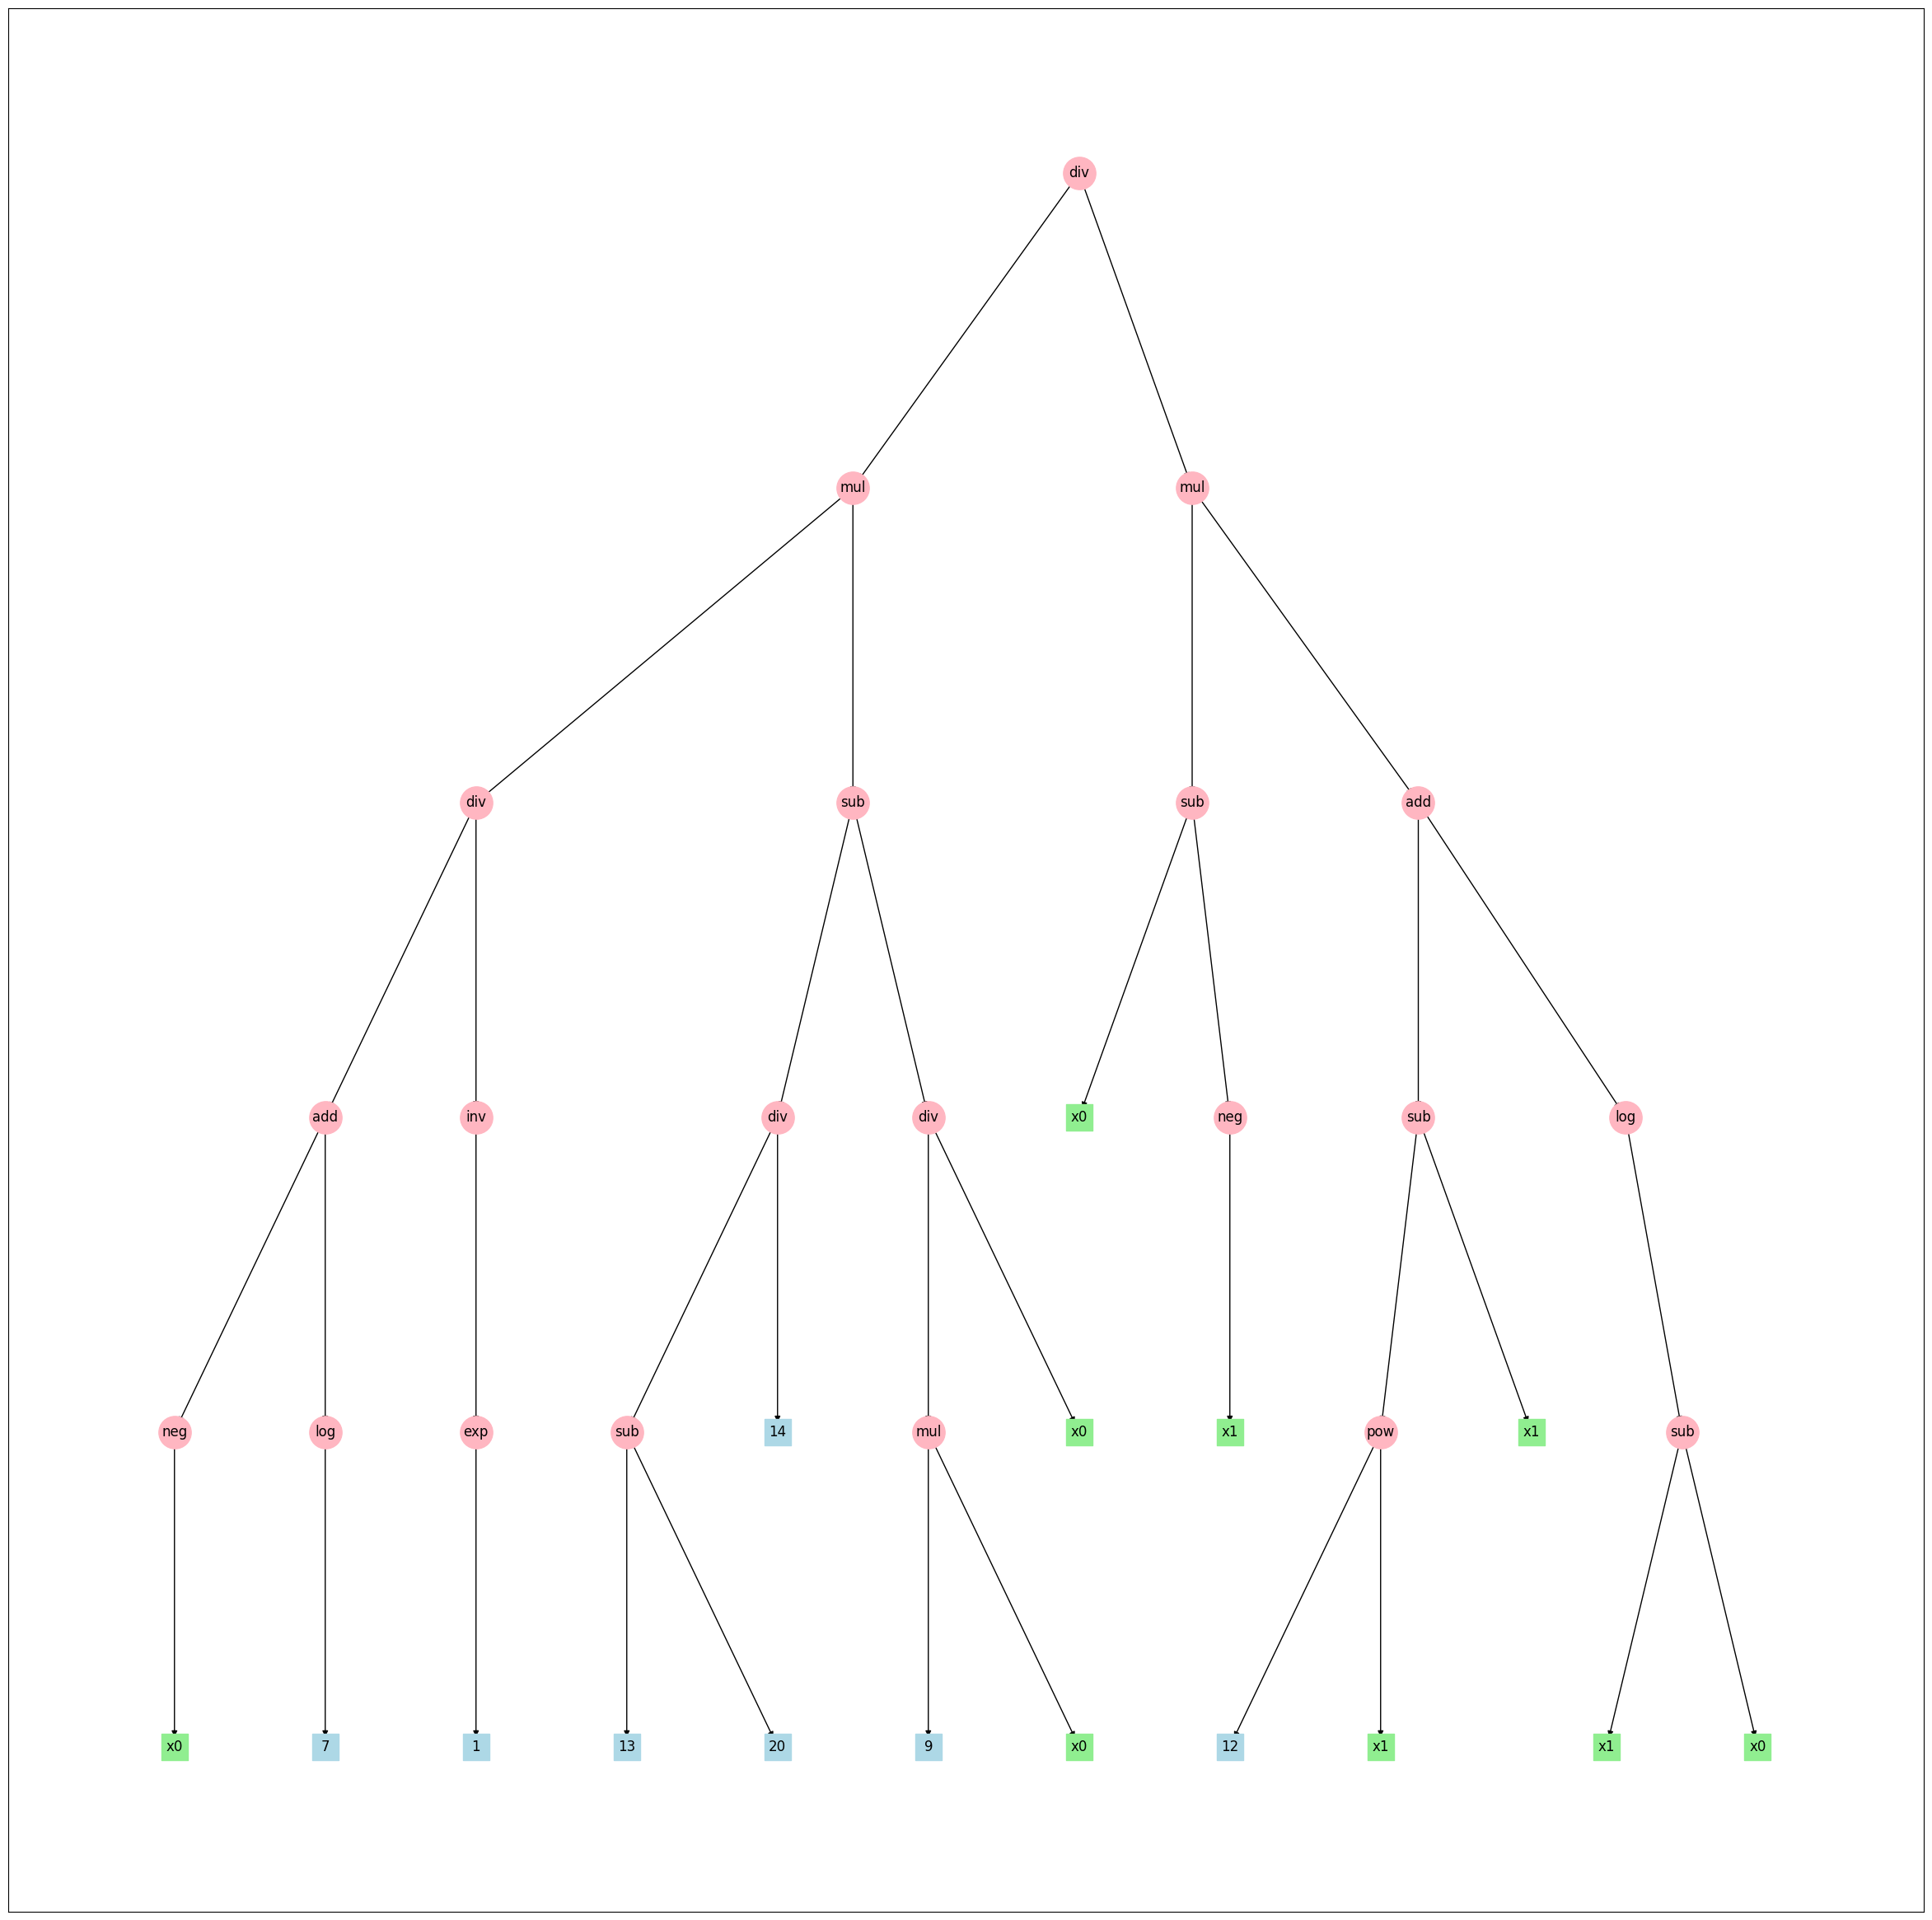

In [3]:
from utils.terminal_constants import crammed_constants
from utils.evolution import generate_random_tree, point_mutation, subtree_mutation

height = 5
initialized = generate_random_tree(height, 0.2, terminal_list, constants=crammed_constants, p_pick_constant=0.4, p_cut_tree=0.2)
initialized.draw()


Create input formatted

In [4]:
vars = {'x'+str(i): input[:,0][i] for i in range(input.shape[0])}
initialized(**vars)

np.float64(-4.637659628654987)

In [5]:
# Fitness
def fitness(mytree, vars, labels):
    return 100*np.square(labels - mytree(**vars)).sum()/len(labels)

In [9]:
from gxgp.gp_common import xover_swap_subtree
# Xover
def xover(tree1, tree2):
    return xover_swap_subtree(tree1, tree2)

# initialized.subtree.pop().draw() # this procedure is really similar to get_random_node, except there we use a list and random.choice
subtree_mutation(initialized,terminal_list,crammed_constants,0.2,verbose=True).draw()

Node to mutate: 12 at height 0


IndexError: list index out of range

## Training